# Readers target words where they expect to minimize uncertainty

## Analysis notebook

This Jupyter notebook runs through all the analyses described in the paper. Most of the code is contained in the `code/` directiory, which is set up as a Python module. First, we will import this module so that we have access to the main codebase throughout this notebook.

In [1]:
%matplotlib inline

from code import *
from code import model
from code import model_predict

import arviz

## Preprocessing of word-frequency data

In order to perform the cross-linguistic analyses, we need word lists and word frequency data for a variety of languages. I have already collected this information for Dutch, English, German, Greek, Hebrew, Italian, Polish, Spanish, and Swahili, and the relevant word-frequency data is included in this repo under `data/lang_word_probs/`. Therefore, **the following cell does NOT need to be run** and is only included to document the preprocessing steps I performed. **You can safely skip to the next section**, unless you are interested in reproducing the word frequencies or analyzing a new language.

The raw Subtlex data is a bit messy and inconsistent and requires some preprocessing. The original Subtlex CSV files should be stored under `data/subtlex/` but I have not committed them to this public git repo because they are not mine to publish. If you want to reproduce these steps, you will first need to obtian the relevant Subtlex data files and place them in this directory.

From the raw Subtlex files we will pull out the counts of 5-9 letter words. We will only consider words that are composed of native characters (as defined for each language below). All words will be lowercased and any accents will be stripped. For example, for Dutch, the Subtlex file is encoded in UTF-8, it uses a tab separator, the relevant headers are "Word" and "FREQcount", a valid wordform is a sequence of 5-9 letters from A-Z, and no accents need to be stripped. Swahili is processed in the same way, except that the counts are pulled from a continuous text file under `data/corpora/` (although, again, the raw data file is not included in this repo).

Once the counts have been extracted, the `separate_and_reduce()` function partitions the counts by word length (i.e. into "lexicons"), reduces each lexicon to 3000 words (+ words that have the same freq as the 3000th word), and converts the freqs to probabilities. Finally, the probabilities are written to JSON files under `data/lang_word_probs/`.

In [2]:
# from code import corpus_freqs

# print('DUTCH')
# nl_freqs = corpus_freqs.count_subtlex(
#     DATA/'subtlex'/'SUBTLEX-NL.cd-above2.txt',
#     encoding = 'utf-8',
#     separator = '\t',
#     word_header = 'Word',
#     freq_header = 'FREQcount',
#     wordform = r'[a-z]{5,9}',
#     accents = {},
# )
# nl_probs = corpus_freqs.separate_and_reduce(nl_freqs, target_lexicon_size=3000)
# json_write(nl_probs, DATA/'lang_word_probs'/'nl.json', compress=True)

# print('ENGLISH')
# en_freqs = corpus_freqs.count_subtlex(
#     DATA/'subtlex'/'SUBTLEXus74286wordstextversion.txt',
#     encoding = 'ascii',
#     separator = '\t',
#     word_header = 'Word',
#     freq_header = 'FREQcount',
#     wordform = r'[a-z]{5,9}',
#     accents = {},
# )
# en_probs = corpus_freqs.separate_and_reduce(en_freqs, target_lexicon_size=3000)
# json_write(en_probs, DATA/'lang_word_probs'/'en.json', compress=True)

# print('GERMAN')
# de_freqs = corpus_freqs.count_subtlex(
#     DATA/'subtlex'/'SUBTLEX-DE_cleaned_with_Google00.txt',
#     encoding = 'latin1',
#     separator = '\t',
#     word_header = 'Word',
#     freq_header = 'WFfreqcount',
#     wordform = r'[a-zßäöü]{5,9}',
#     accents = {'ä':'a', 'ö':'o', 'ü':'u'},
# )
# de_probs = corpus_freqs.separate_and_reduce(de_freqs, target_lexicon_size=3000)
# json_write(de_probs, DATA/'lang_word_probs'/'de.json', compress=True)

# print('GREEK')
# gr_freqs = corpus_freqs.count_subtlex(
#     DATA/'subtlex'/'SUBTLEX-GR_full.txt',
#     encoding = 'utf-8',
#     separator = '\t',
#     word_header = '"Word"',
#     freq_header = '"FREQcount"',
#     wordform = r'[αβγδεζηθικλμνξοπρσςτυφχψωάέήίόύώϊϋΐΰ]{5,9}',
#     accents = {'ά':'α', 'έ':'ε', 'ή':'η', 'ί':'ι', 'ό':'ο', 'ύ':'υ', 'ώ':'ω', 'ϊ':'ι', 'ϋ':'υ', 'ΐ':'ι', 'ΰ':'υ'},
# )
# gr_probs = corpus_freqs.separate_and_reduce(gr_freqs, target_lexicon_size=3000)
# json_write(gr_probs, DATA/'lang_word_probs'/'gr.json', compress=True)

# print('Hebrew')
# he_freqs = corpus_freqs.count_subtlex(
#     DATA/'subtlex'/'dedup.he.words.unigrams.tsv',
#     encoding = 'utf-8',
#     separator = '\t',
#     word_header = 'unigram',
#     freq_header = 'unigram_freq',
#     wordform = '[\u0590-\u05fe]{5,9}',
#     accents = {},
#     rtl = True,
# )
# he_probs = corpus_freqs.separate_and_reduce(he_freqs, target_lexicon_size=3000)
# json_write(he_probs, DATA/'lang_word_probs'/'he.json', compress=True)

# print('ITALIAN')
# it_freqs = corpus_freqs.count_subtlex(
#     DATA/'subtlex'/'subtlex-it.csv',
#     encoding = 'utf-8',
#     separator = ',',
#     word_header = '"spelling"',
#     freq_header = '"FREQcount"',
#     wordform = r'[abcdefghilmnopqrstuvzàéèíìóòúù]{5,9}',
#     accents = {'à':'a', 'é':'e', 'è':'e', 'í':'i', 'ì':'i', 'ó':'o', 'ò':'o', 'ú':'u', 'ù':'u'},
# )
# it_probs = corpus_freqs.separate_and_reduce(it_freqs, target_lexicon_size=3000)
# json_write(it_probs, DATA/'lang_word_probs'/'it.json', compress=True)

# print('POLISH')
# pl_freqs = corpus_freqs.count_subtlex(
#     DATA/'subtlex'/'subtlex-pl-cd-3.csv',
#     encoding = 'utf-8',
#     separator = '\t',
#     word_header = 'spelling',
#     freq_header = 'freq',
#     wordform = r'[abcdefghijklłmnoprstuwyząćęńóśźż]{5,9}',
#     accents = {'ą':'a', 'ć':'c', 'ę':'e', 'ń':'n', 'ó':'o', 'ś':'s', 'ź':'z', 'ż':'z'},
# )
# pl_probs = corpus_freqs.separate_and_reduce(pl_freqs, target_lexicon_size=3000)
# json_write(pl_probs, DATA/'lang_word_probs'/'pl.json', compress=True)

# print('SPANSIH')
# es_freqs = corpus_freqs.count_subtlex(
#     DATA/'subtlex'/'SUBTLEX-ESP.tsv',
#     encoding = 'utf-8',
#     separator = '\t',
#     word_header = 'Word',
#     freq_header = 'Freq. count',
#     wordform = r'[abcdefghijlmnopqrstuvxyzñáéíóúü]{5,9}',
#     accents = {'ñ':'n', 'á':'a', 'é':'e', 'í':'i', 'ó':'o', 'ú':'u', 'ü':'u'},
# )
# es_probs = corpus_freqs.separate_and_reduce(es_freqs, target_lexicon_size=3000)
# json_write(es_probs, DATA/'lang_word_probs'/'es.json', compress=True)

# print('SWAHILI')
# sw_freqs = corpus_freqs.count_corpus(
#     DATA/'corpora'/'sw_helsinki.txt',
#     wordform = r'[abcdefghijklmnoprstuvwyz]{5,9}'
# )
# sw_probs = corpus_freqs.separate_and_reduce(sw_freqs, target_lexicon_size=3000)
# json_write(sw_probs, DATA/'lang_word_probs'/'sw.json', compress=True)

## Model

The code for the cognitive model is contained in `code/model.py`, which was already imported above. First, let's test that the model reader produces some sensible output. We'll load the English-7 lexicon and use this in subsequent cells.

In [3]:
en_probs = json_read(DATA / 'lang_word_probs' / 'en.json')
lexicon = en_probs['7']

Now we instantiate a reader with the English-7 lexicon and a certain perceptual filter, and then expose it to the word "guarded" in central position (position 3 counting from 0). You can play around with the parameters to explore what happens under different languages, word lengths, fixation positions, and perceptual filters. For example, you should find that the reader usually identifies the word correctly when fixating in initial position (0) but incorrectly when fixating in final position (6).

In [4]:
reader = model.Reader(lexicon, alpha=0.9, beta=0.2, gamma=0.0)
reader.read('guarded', fixation_position=3)

   Target (t): guarded
 Fixation (j):    ^
  Percept (p): guprded
Inference (w): guarded
Selection (o): guarded


To provide some examples in the paper, I computed the top ten inferences made by the model reader when fixating the words "guarded" and "concern" in initial, central, and final position. Here is the code to do it. In the paper, I also show results with `gamma` set to `0.5` (right-visual-field advantage).

In [5]:
reader = model.Reader(lexicon, alpha=0.9, beta=0.2, gamma=0.0)

N_SIMS = 100000

for target_word in ['guarded', 'concern']:
    target_word_i = reader.get_index_from_word(target_word)

    for fixation_position in [0, 3, 6]: # initial, central, and final positions
        print(f'{target_word} in position {fixation_position+1}')
        
        p_w_given_t = reader.p_word_given_target(target_word_i, fixation_position, n_sims=N_SIMS)
        top_ten_words = reversed(p_w_given_t.argsort()[-10:])

        for inferred_word_i in top_ten_words:
            inferred_word = reader.get_word_from_index(inferred_word_i)
            percentage = round(p_w_given_t[inferred_word_i] * 100, 1)
            print(f'{percentage}%', inferred_word)

guarded in position 1
79.2% guarded
2.0% guessed
1.5% grandma
1.3% quarter
1.1% granted
1.0% glasses
1.0% started
0.8% grabbed
0.5% gunshot
0.4% learned
guarded in position 4
65.3% guarded
6.9% started
3.1% married
2.2% awarded
2.1% boarded
1.8% learned
1.8% quarter
1.1% decided
1.1% charged
0.8% charles
guarded in position 7
16.7% decided
15.3% married
13.1% started
8.6% guarded
2.9% learned
2.5% wounded
2.4% hundred
2.4% changed
2.0% husband
1.4% worried
concern in position 1
77.7% concern
1.6% control
1.5% concert
1.2% country
1.0% conceal
1.0% college
0.8% concede
0.7% concept
0.6% condemn
0.6% contest
concern in position 4
85.2% concern
1.1% concert
0.7% sincere
0.7% dancers
0.6% chicken
0.5% conceal
0.4% popcorn
0.3% concede
0.3% vincent
0.3% lincoln
concern in position 7
58.5% concern
5.3% between
2.3% pattern
2.2% chicken
2.1% captain
2.1% shouldn
1.7% goddamn
1.7% western
1.6% popcorn
1.0% kitchen


### Uncertainty

The code below can be used to compute how much uncertainty the reader will experience when fixating in a given position. I ran this with 1000 sims, but since it's quite slow, we'll run it here with 10 sims.

In [6]:
N_SIMS = 10

reader = model.Reader(lexicon, alpha=0.9, beta=0.2, gamma=0.0)
uncertainty = reader.uncertainty(fixation_position=3, n_sims=N_SIMS)
print(uncertainty)

1.0591610468026789


You could run the above code for all 45 lexicons (nine languages × five lengths) and all positions within each lexicon (315 positions in total), but this will take a long time (~50 hours). I performed this process on a Slurm cluster and have included the results in this repo under `data/lang_uncertainty/`. If for some reason you want to replicate this process, perhaps for a new language, here are the steps I followed; however, this is likely to be quite different depending on your cluster (see `code/unc_compute.py` for more details). First, we create shell scripts to submit to the cluster:

```bash
$ python code/unc_compute.py --script
```

Then submit the scripts as array jobs (each fixation position is run on a separate core):

```bash
$ sbatch --array=0-4 -p cluster_name en_5.sh
$ sbatch --array=0-5 -p cluster_name en_6.sh
$ sbatch --array=0-6 -p cluster_name en_7.sh
$ sbatch --array=0-7 -p cluster_name en_8.sh
$ sbatch --array=0-8 -p cluster_name en_9.sh
```

Finally, merge the results together into JSON files for each language:

```bash
$ python code/unc_compute.py --merge
```

I performed this process with 1000 simulations and for two different perceptual filters:

```
data/lang_uncertainty/gamma0.0/   α=0.9, β=0.2, γ=0.0
data/lang_uncertainty/gamma0.5/   α=0.9, β=0.2, γ=0.5
```

Finally, we will plot uncertainty by letter position for each of the lexicons using both the symmetrical and asymmetrical perceptual filters. This uses the uncertainty estimates that were precomputed above and stored under `data/lang_uncertainty/`. In the case of Hebrew, I also show results under the assumption of a left-visual-field advantage (γ = -0.5).

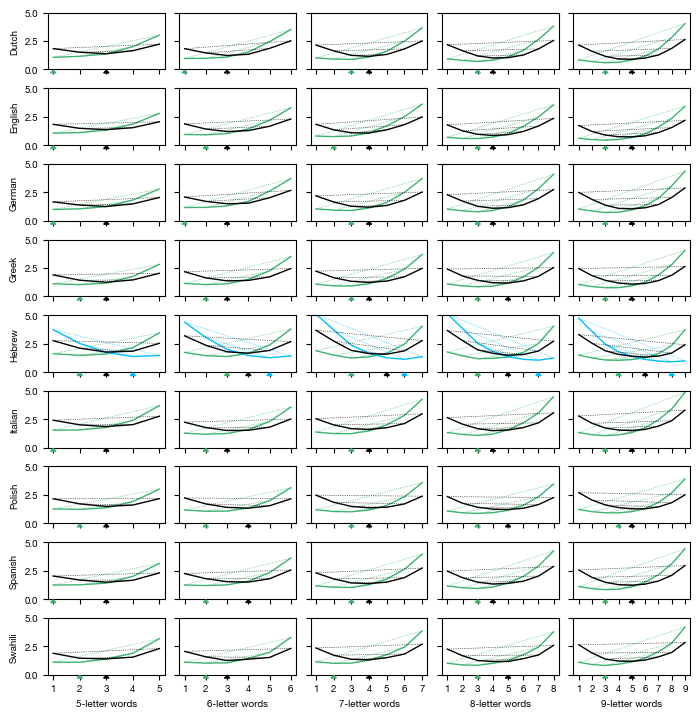

In [7]:
languages = {
    'nl': 'Dutch',
    'en': 'English',
    'de': 'German',
    'gr': 'Greek',
    'he': 'Hebrew',
    'it': 'Italian',
    'pl': 'Polish',
    'es': 'Spanish',
    'sw': 'Swahili',
}

with Figure(n_rows=9, n_cols=5, width='double', height=180) as fig:
    for i, (lang, lang_name) in enumerate(languages.items()):
        uncertainty_symm = json_read(DATA / 'lang_uncertainty' / 'gamma0.0' / f'{lang}.json')
        uncertainty_RVFA = json_read(DATA / 'lang_uncertainty' / 'gamma0.5' / f'{lang}.json')
        if lang == 'he':
            uncertainty_LVFA = json_read(DATA / 'lang_uncertainty' / 'gamma-0.5' / f'{lang}.json')
        for j, length in enumerate(range(5, 10)):
            plots.plot_uncertainty(fig[i,j], uncertainty_RVFA[str(length)], color='MediumSeaGreen', show_min=True)
            if lang == 'he':
                plots.plot_uncertainty(fig[i,j], uncertainty_LVFA[str(length)], color='DeepSkyBlue', show_min=True)
            plots.plot_uncertainty(fig[i,j], uncertainty_symm[str(length)], color='black', show_min=True)
            fig[i,j].set_xlabel(f'{length}-letter words')
            fig[i,j].set_ylabel(lang_name)
            fig[i,j].set_ylim(0, 5)

## Experiment 1

Experiment 1 was run online on Prolific, so the experimental code is in JavaScript (with a node.js backend). If you want to explore the experimental code, see `experiments/exp1/`.

To analyze the data from Experiment 1, we will first load the data into an `Experiment` object. This is a custom object which abstracts away a lot of detail about how the data is stored and how stuff is calculated. However, you can always check the details by looking at the relevant class methods in `code/experiment.py`.

At this point, we will also set the exclusion threshold to 7 out of 8, and specify the parameter bounds and priors. (N.B. we will use beta distributions to express our certainty about the model parameters before running the experiment; these beta distributions in [0,1] will be transformed to the relevant parameter bounds under the hood).

In [8]:
exp1 = Experiment('exp1')

exp1.set_exclusion_threshold(7, 8)

exp1.set_params({
    'α': ( 0.0625, 0.9999),
    'β': ( 0.0001, 1.0000),
    'γ': (-0.9999, 0.9999),
    'ε': ( 0.0001, 0.9999),
})

exp1.set_priors({
    'α': ('beta', (8, 2)),
    'β': ('beta', (2, 8)),
    'γ': ('beta', (4, 2)),
    'ε': ('beta', (2, 16)),
})

Print the comments made by participants:

In [9]:
# exp1.print_comments()

Print the median completion time:

In [10]:
exp1.print_median_completion_time(use_first_trial_time=True)

Median completion time of 22 minutes


Print the median bonus earned:

In [11]:
exp1.print_median_bonus()

Median bonus: 99


Print details about overall test accuracy:

In [12]:
exp1.print_test_accuracy()

exp1_left: median = 0.8392857142857143, IQR = 0.7142857142857143 -- 0.9017857142857143
exp1_right: median = 0.875, IQR = 0.8214285714285714 -- 0.9285714285714286


Produce a plot of the overall experimental results:

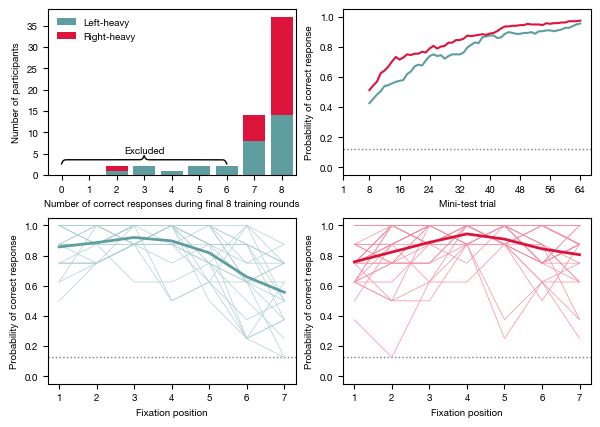

In [13]:
with Figure(n_rows=2, n_cols=2, width=150) as fig:
    plots.plot_learning_scores(fig[0,0], exp1)
    plots.plot_learning_curve(fig[0,1], exp1)
    plots.plot_test_curve(fig[1,0], exp1.left)
    plots.plot_test_curve(fig[1,1], exp1.right)
    fig.auto_deduplicate_axes = False

### Model fit

Performing the model fit requires PyMC and will take some time to run. The posteriors have already been computed and are stored as NetCDF files under `data/model_fit/`. However, if you want to reproduce the results or play around with the details, you should take a look at `code/model_fit.py`. In short, each MCMC chain needs to be run separately like this (PyMC's built-in parallelization doesn't play nice with the blackbox likelihood):

```bash
$ python code/model_fit.py run 0
$ python code/model_fit.py run 1
$ python code/model_fit.py run 2
$ python code/model_fit.py run 3
$ python code/model_fit.py run 4
$ python code/model_fit.py run 5
```

Once the chains have been run, they can be merged together into a single NetCDF file like this:

```bash
$ python code/model_fit.py merge 6
```

I performed the model fit with six chains of 2500 samples (+ 500 tuning samples) with 10000 model simulations used for each sample. This takes 8+ hours per chain. The posterior trace is stored in `data/model_fit/exp1_posterior.nc`.

First, let's make a plot of the posterior parameter estimates:

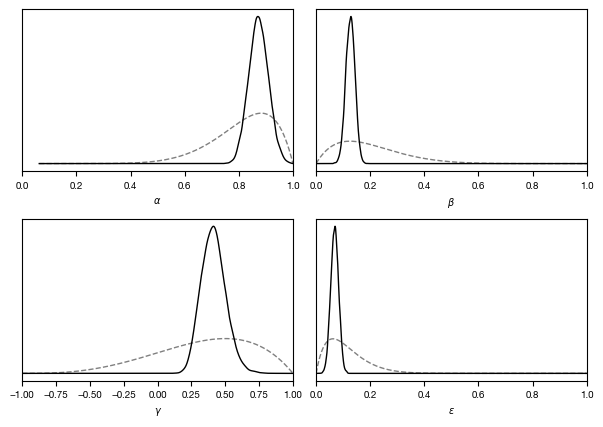

In [14]:
with Figure(n_cols=2, n_rows=2, width=150) as fig:
    for param, axis in zip(['α', 'β', 'γ', 'ε'], fig):
        plots.plot_prior(axis, exp1, param, transform_to_param_bounds=True)
        plots.plot_posterior(axis, exp1, param)
    fig.auto_deduplicate_axes = False

The posteriors (solid curves) look pretty good and more-or-less match our prior expectations (dashed curves). The baseline probability of correctly identifying the character under fixation (α) is around 90%-ish (which sounds plausible). The probability of making a selection error (ε) is around 5%-ish (also plausible). And the visual span asymmetry (γ) comes out positive (around 0.4) and non-zero, which matches our expectations.

I also performed the model fit using uniform priors (strored in `exp1_posterior_uniform.nc`) and using the left (`exp1_posterior_left.nc`) and right (`exp1_posterior_right.nc`) datasets independently. Here's a figure comparing these three alternative methods with the canonical results:

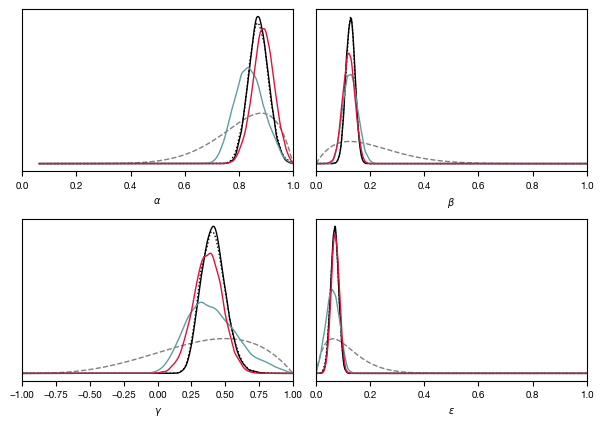

In [15]:
with Figure(n_cols=2, n_rows=2, width=150) as fig:
    for param, axis in zip(['α', 'β', 'γ', 'ε'], fig):
        plots.plot_prior(axis, exp1, param, transform_to_param_bounds=True)
        plots.plot_posterior(axis, exp1, param)
        plots.plot_posterior(axis, exp1, param,
            posterior_file=MODEL_FIT / 'exp1_posterior_uniform.nc', linestyle=':')
        plots.plot_posterior(axis, exp1.left, param,
            posterior_file=MODEL_FIT / 'exp1_posterior_left.nc')
        plots.plot_posterior(axis, exp1.right, param,
            posterior_file=MODEL_FIT / 'exp1_posterior_right.nc')
    fig.auto_deduplicate_axes = False

The posterior estimated using a uniform prior (dotted curve) looks almost identical to the canonical posterior (solid curve), so our choice of priors is not unduely biasing the posteriors. The posteriors estimated based on the left- and right-heavy datasets independently should theoretically be the same, since participants' perceptual filters should be the same regardless of which lexicon they were exposed to. In general the two posteriors (red and blue curves) are closely aligned, although the posterior estimated from the left-heavy dataset (blue) does tend to deviate a little. That being said there's also quite a lot of uncertainty associated with the left-heavy estimates, probably because there were fewer participants in the left-heavy condition after exclusions.

Here is a detailed table of all the parameter estimates:

In [16]:
posteriors = [
    ('exp1_posterior.nc', 'Canonical posterior parameter estimates'),
    ('exp1_posterior_uniform.nc', 'Posterior estimated with uniform priors'),
    ('exp1_posterior_left.nc', 'Posterior estimated from left-heavy dataset only'),
    ('exp1_posterior_right.nc', 'Posterior estimated from right-heavy dataset only'),
]

for filename, title in posteriors:
    trace = arviz.from_netcdf(MODEL_FIT / filename)
    table = arviz.summary(trace, hdi_prob=0.95)
    table = table[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%', 'ess_bulk', 'r_hat']]
    print(title)
    print(table)

Canonical posterior parameter estimates
    mean     sd  hdi_2.5%  hdi_97.5%  ess_bulk  r_hat
α  0.873  0.036     0.800      0.942    1576.0    1.0
β  0.127  0.017     0.094      0.159    2564.0    1.0
γ  0.413  0.090     0.246      0.594    5954.0    1.0
ε  0.069  0.014     0.042      0.098    2046.0    1.0
Posterior estimated with uniform priors
    mean     sd  hdi_2.5%  hdi_97.5%  ess_bulk  r_hat
α  0.873  0.038     0.799      0.948    1405.0    1.0
β  0.127  0.017     0.094      0.161    2270.0    1.0
γ  0.411  0.092     0.238      0.593    5614.0    1.0
ε  0.068  0.015     0.039      0.099    2002.0    1.0
Posterior estimated from left-heavy dataset only
    mean     sd  hdi_2.5%  hdi_97.5%  ess_bulk  r_hat
α  0.839  0.053     0.742      0.946    1283.0    1.0
β  0.127  0.027     0.076      0.178    1397.0    1.0
γ  0.406  0.185     0.077      0.792    2104.0    1.0
ε  0.062  0.024     0.015      0.107    1811.0    1.0
Posterior estimated from right-heavy dataset only
    mean   

All R-hats are 1, suggesting good convergence of the MCMC chains. All ESS > 1000 providing us with a decent number of effective samples.

We now run posterior predictive checks. First, we simulate 100 experimental datasets based on the joint posterior estimated above (i.e. the canonical posterior estimated from the experimental data as a whole). Specifically, we draw a set of parameter values from the posterior and instantiate N Readers with that set of values (N = number of participants after excludes, which is inferred automatically from the Experiment object). We then subject each Reader to the test (each word is tested in each fixation position) and record all the trials in a big dataset. Each dataset contains trials of the form (0, 3, 4, 3), correspondinng to (lexicon_index, target word, position, inferred object).

Then, we plot the mean test curve for each of these simulated datasets and also the mean test curve for the actual experimental results. If the model and model parameter estimates are okay, the actual experimental results should fall within the posterior predictive distribution.

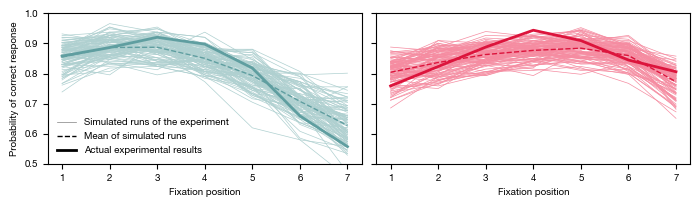

In [17]:
sim_datasets = model_predict.simulate_from_posterior(exp1, n_sims=100)

with Figure(n_cols=2, width='double', height=50) as fig:
    plots.plot_posterior_predictive(fig[0,0], sim_datasets, exp1.left, lexicon_index=0, show_legend=True)
    plots.plot_posterior_predictive(fig[0,1], sim_datasets, exp1.right, lexicon_index=1)

The real exerimental results generally fall within the posterior predictive distribution, suggesting that the experimental findings can be explained nicely by an interaction between the lexicon and right-visual-field advantage.

Lastly, we plot the uncertainty curve for each lexicon, taking into account the asymmetry in the visual span. To do this, we instantiate a Reader with the best fitting parameter values estimated from the experiment and compute uncertainty over letter positions.

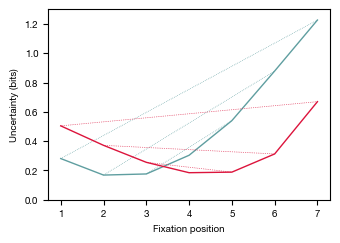

In [18]:
uncertainty_left, uncertainty_right = model_predict.uncertainty_curve_from_posterior(exp1, n_sims=10000)

with Figure() as fig:
    plots.plot_uncertainty(fig, uncertainty_left, color=exp1.left.color)
    plots.plot_uncertainty(fig, uncertainty_right, color=exp1.right.color)
    fig[0,0].set_ylim(0, 1.3)

This plot reveals that uncertainty is not mirrored across the two lexicons. In the left-heavy lexicon, uncertainty is strongly minimized in positions 2 and 3; in the right-heavy lexicon, uncertainty is minimized in positions 4 or 5, although it remains relatively low in most positions. This yields distinctive predictions for each condition.

## Experiment 2

Experiment 2 was run in the lab with an EyeLink eye tracker. If you want to explore the experimental code, see `experiments/exp2/`.

First, some notes on the preprocessing of the eyetracking data. For each participant, the experiment script produces three files: `01.json`, `01.edf`, and `01.asc`. The JSON file stores all the data about trial order, button clicks etc, the EDF file stores the raw eyetracker recording, and the ASC file is a conversion of the EDF file to an open format (produced using EyeLink's `edf2asc` tool).

From the ASC file, we extract the fixation sequence and store it inside the JSON file to keep everything neatly organized together. The raw ASC and EDF files are not committed to the repo because they are very large (contact me if you want this raw data). The extraction process is run like this:

```python
from code import merge_fixation_data
merge_fixation_data.merge_fixations_into_user_data(json_path, asc_path)
```

This uses Eyekit to extract the fixations from the ASC file and then inserts them into the JSON file. It also performs a number of checks to make sure the recordings in the ASC file match the trials in the JSON file, and also creates Eyekit TextBlock objects for each trial (also stored in the JSON).

Alternatively, the extraction process can be run from the command line, e.g.:

```bash
$ python code/merge_fixation_data.py exp2_left 01
```

Note, however, that the JSON files committed to the repo have already been processed, so **it is not necessary to run any of these preprocessing steps unless you need to reproduce the data for some reason**.

Like Experiment 1, the Experiment 2 dataset will be loaded into an `Experiment` object, and before getting started we need to set up the exclusion threshold and parameters/priors.

In [19]:
exp2 = Experiment('exp2')

exp2.set_exclusion_threshold(7, 8)

exp2.set_params({
    'τ': (0, 252),
    'δ': (0, 60),
    'ζ': (0, 40),
    'ξ': (0, 40),
})

exp2.set_priors({
    'ζ': ('exponential', (0.1,)),
    'ξ': ('exponential', (0.1,)),
})

exp2.left.set_priors({
    'τ': ('normal', (72., 20.)),
    'δ': ('gamma', (20., 8.)),
})

exp2.right.set_priors({
    'τ': ('normal', (144., 20.)),
    'δ': ('gamma', (30., 8.)),
})

Print median completion time:

In [20]:
exp2.print_median_completion_time(use_first_trial_time=False)

Median completion time of 40 minutes


Print details about the number of exclusions and valid trials:

In [21]:
exp2.print_n_exclusion_stats()
exp2.left.print_n_exclusion_stats()
exp2.right.print_n_exclusion_stats()

exp2
80 participants completed training
73 participants remain after training exclusions
- 68 complete datasets (on average 60.5 trials were valid)
- 5 incomplete datasets (on average 34.0 trials were valid)
Total valid trials: 4284 (94.486)
exp2_left
40 participants completed training
37 participants remain after training exclusions
- 33 complete datasets (on average 60.6 trials were valid)
- 4 incomplete datasets (on average 29.5 trials were valid)
Total valid trials: 2119 (94.81)
exp2_right
40 participants completed training
36 participants remain after training exclusions
- 35 complete datasets (on average 60.4 trials were valid)
- 1 incomplete datasets (on average 52.0 trials were valid)
Total valid trials: 2165 (94.171)


Print details about overall test accuracy:

In [22]:
exp2.print_test_accuracy()

exp2_left: median = 0.984375, IQR = 0.9375 -- 1.0
exp2_right: median = 0.984375, IQR = 0.96875 -- 1.0


Make plots of the overall experimental results:

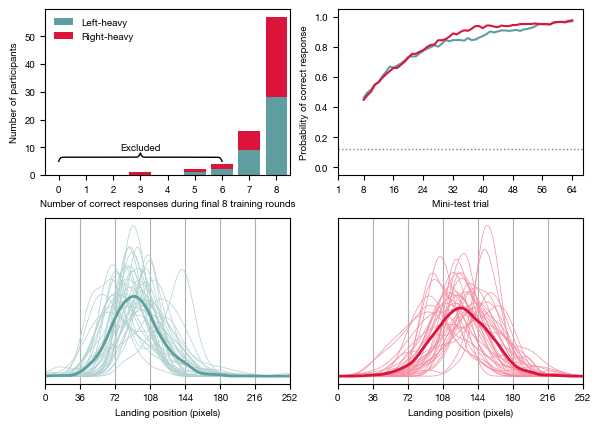

In [23]:
with Figure(n_rows=2, n_cols=2, width=150) as fig:
    plots.plot_learning_scores(fig[0,0], exp2)
    plots.plot_learning_curve(fig[0,1], exp2)
    plots.plot_landing_curve(fig[1,0], exp2.left, show_average=True)
    plots.plot_landing_curve(fig[1,1], exp2.right, show_average=True)

### Fitting statistical model

Fitting the statistical model requires PyMC and will take some time to run. The posteriors have already been computed and are stored as NetCDF files under `data/model_fit/`. However, if you want to reproduce the results or play around with the details, you should take a look at `code/landing_model.py`.

To fit the statistical model, run:

```bash
$ python code/landing_model.py
```

I ran the model with six chains of 2500 samples (+ 500 tuning samples); to adjust these parameters or check out the other available options, run this command:

```bash
$ python code/landing_model.py --help
```

The posterior trace is stored in `data/model_fit/exp2_posterior.nc`. Here is a summary table:

In [24]:
trace = arviz.from_netcdf(MODEL_FIT / 'exp2_posterior.nc')
table = arviz.summary(trace, hdi_prob=0.95, var_names=['τ', 'δ', 'Δ(τ)', 'Δ(δ)'])
table = table[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%', 'ess_bulk', 'r_hat']]
print(table)

             mean     sd  hdi_2.5%  hdi_97.5%  ess_bulk  r_hat
τ[left]    94.007  2.461    89.212     98.885   19656.0    1.0
τ[right]  127.781  2.446   123.109    132.685   18104.0    1.0
δ[left]    21.721  0.818    20.142     23.340   16667.0    1.0
δ[right]   24.248  0.833    22.590     25.865   16661.0    1.0
Δ(τ)       33.774  3.493    27.032     40.615   19123.0    1.0
Δ(δ)        2.527  1.153     0.288      4.839   18546.0    1.0


All R-hats are 1 and all ESS > 10,000, so diagnostics are all good. The parameter estimates hint at a 34 pixel difference in targeted positions (i.e. Δ(τ)) and a small difference in dispersion (Δ(δ) = 2.5 pixels). Here's a figure plotting the priors and posteriors (top row), as well as the posterior differences between the left- and right-heavy conditions:

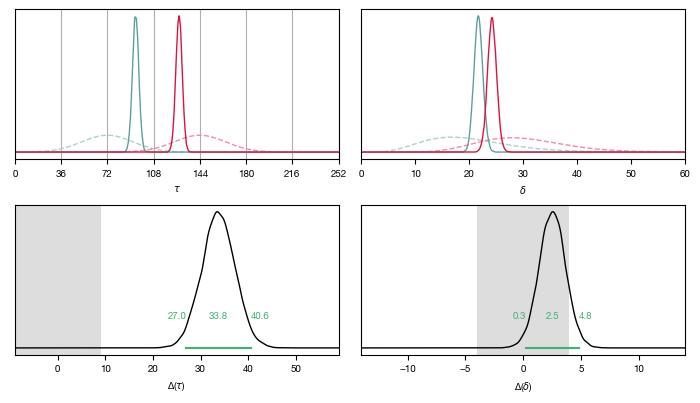

In [25]:
with Figure(n_cols=2, n_rows=2, width='double', height=100) as fig:
    plots.plot_prior(fig[0,0], exp2, 'τ')
    plots.plot_prior(fig[0,1], exp2, 'δ')
    plots.plot_posterior(fig[0,0], exp2, 'τ')
    plots.plot_posterior(fig[0,1], exp2, 'δ')
    plots.plot_posterior_difference(fig[1,0], exp2, 'τ', hdi=0.95, rope=(-9, 9), xlim=(-9, 59))
    plots.plot_posterior_difference(fig[1,1], exp2, 'δ', hdi=0.95, rope=(-4, 4), xlim=(-14, 14))
    plots.draw_letter_grid(fig[0,0], letter_width=36, n_letters=7)

Hypothesis 1 is clearly validated (the posterior difference is well above the ROPE). In the case of Hypothesis 2, however, the 95% HDI and ROPE overlap, meaning we have inconclusive evidence. Let's quantify our beliefs:

In [26]:
import numpy as np

def proportion_of_mass_below(trace, param, x):
    samples = trace.posterior[param].to_numpy().flatten()
    return sum(samples < x) / len(samples)

def proportion_of_mass_above(trace, param, x):
    samples = trace.posterior[param].to_numpy().flatten()
    return sum(samples > x) / len(samples)

def proportion_of_mass_within(trace, param, x1, x2):
    samples = trace.posterior[param].to_numpy().flatten()
    return sum(np.logical_and(samples > x1, samples < x2)) / len(samples)

print('Proportion of posterior mass above 0')
print(proportion_of_mass_above(trace, 'Δ(δ)', 0))
print('Proportion of posterior mass within ROPE')
print(proportion_of_mass_within(trace, 'Δ(δ)', -4, 4))
print('Proportion of posterior mass above upper ROPE bound')
print(proportion_of_mass_above(trace, 'Δ(δ)', 4))
print('Proportion of posterior mass below 0')
print(proportion_of_mass_below(trace, 'Δ(δ)', 0))

Proportion of posterior mass above 0
0.9847333333333333
Proportion of posterior mass within ROPE
0.9012666666666667
Proportion of posterior mass above upper ROPE bound
0.09873333333333334
Proportion of posterior mass below 0
0.015266666666666666


98% of the posterior probability mass is above 0, suggesting an effect on dispersion, but also 90% of the mass is within the ROPE, so if there is an effect it is likely to be of a negligible magnitude. About 10% of the mass is beyond the ROPE, so there's some possibility that the true effect is of an interesting size. But also, there's a non-zero probability (1.5%) that the true effect goes in the opposite direction (more dispersion in left-heavy condition). So, overall, results for Hypothesis 2 are unclear.

The following plot shows Normal landing distributions using the partially-pooled parameter estimates, not just for each condition, but also for each participant. Participants whose data were unreliable or divergent will be shrunk towards the group level estimates.

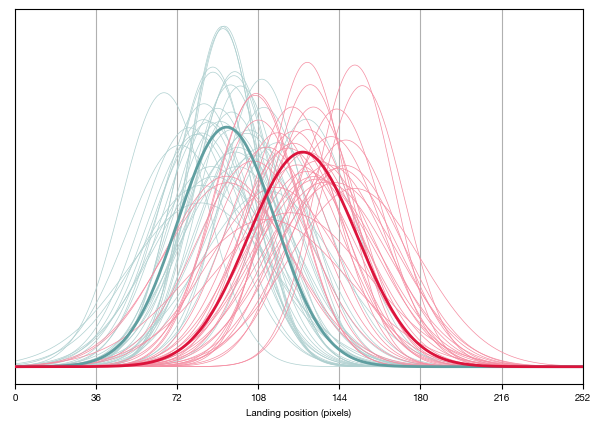

In [27]:
with Figure(width=150) as fig:
    plots.plot_landing_curve_fits(fig, exp2)

The basic statistical model above has a single ζ and a single ξ, implying that the amount of across-participant variation will be the same in each condition. However, perhaps this was not the case – perhaps, for example, participants in the left-heavy condition tend to behave in the same way while participants in the right-heavy condition use very different strategies. To check this, I ran the model with ζ and ξ stratefied by condition and the results are stored in `exp2_posterior_indy_ζξ.nc`. Here's a plot of the posteriors:

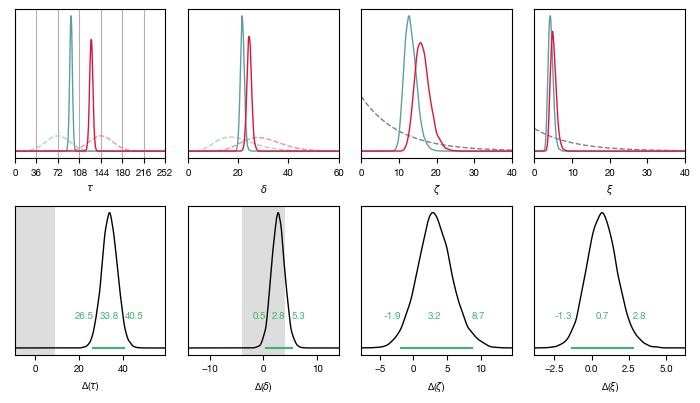

In [28]:
with Figure(n_cols=4, n_rows=2, width='double', height=100) as fig:

    plots.plot_prior(fig[0,0], exp2, 'τ')
    plots.plot_prior(fig[0,1], exp2, 'δ')
    plots.plot_posterior(fig[0,0], exp2, 'τ', posterior_file=MODEL_FIT / 'exp2_posterior_indy_ζξ.nc')
    plots.plot_posterior(fig[0,1], exp2, 'δ', posterior_file=MODEL_FIT / 'exp2_posterior_indy_ζξ.nc')
    plots.plot_posterior_difference(fig[1,0], exp2, 'τ', hdi=0.95, rope=(-9, 9), xlim=(-9, 59), posterior_file=MODEL_FIT / 'exp2_posterior_indy_ζξ.nc')
    plots.plot_posterior_difference(fig[1,1], exp2, 'δ', hdi=0.95, rope=(-4, 4), xlim=(-14, 14), posterior_file=MODEL_FIT / 'exp2_posterior_indy_ζξ.nc')
    plots.draw_letter_grid(fig[0,0], letter_width=36, n_letters=7)

    plots.plot_prior(fig[0,2], exp2, 'ζ')
    plots.plot_prior(fig[0,3], exp2, 'ξ')
    plots.plot_posterior(fig[0,2], exp2, 'ζ', posterior_file=MODEL_FIT / 'exp2_posterior_indy_ζξ.nc')
    plots.plot_posterior(fig[0,3], exp2, 'ξ', posterior_file=MODEL_FIT / 'exp2_posterior_indy_ζξ.nc')
    plots.plot_posterior_difference(fig[1,2], exp2, 'ζ', hdi=0.95, posterior_file=MODEL_FIT / 'exp2_posterior_indy_ζξ.nc')
    plots.plot_posterior_difference(fig[1,3], exp2, 'ξ', hdi=0.95, posterior_file=MODEL_FIT / 'exp2_posterior_indy_ζξ.nc')

First, note that running the model this way has little impact on the estimates for τ and δ. In the case of ξ, the two conditions are practically identical – the amount of across-participant variation in dispersion is the same for both conditions. In the case of ζ, there is some evidence to suggest that there might be more across-participant variation in targeting in the right-heavy condition, although the posterior difference between ζ's does not exclude 0. Overall then, there doesn't seem to be much benefit in running the model this way, so we stick to the canonical version of the model.

To check that the posteriors were not unduely influenced by the priors, we also ran it with uniform priors. The results are stored in `exp2_posterior_uniform.nc` and here's a plot of the results:

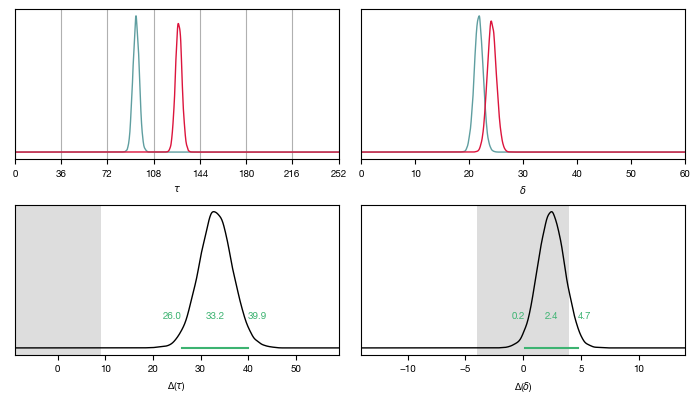

In [29]:
with Figure(n_cols=2, n_rows=2, width='double', height=100) as fig:
    plots.plot_posterior(fig[0,0], exp2, 'τ', posterior_file=MODEL_FIT / 'exp2_posterior_uniform.nc')
    plots.plot_posterior(fig[0,1], exp2, 'δ', posterior_file=MODEL_FIT / 'exp2_posterior_uniform.nc')
    plots.plot_posterior_difference(fig[1,0], exp2, 'τ', hdi=0.95, rope=(-9, 9), xlim=(-9, 59), posterior_file=MODEL_FIT / 'exp2_posterior_uniform.nc')
    plots.plot_posterior_difference(fig[1,1], exp2, 'δ', hdi=0.95, rope=(-4, 4), xlim=(-14, 14), posterior_file=MODEL_FIT / 'exp2_posterior_uniform.nc')
    plots.draw_letter_grid(fig[0,0], letter_width=36, n_letters=7)

Using uniform priors does not make any meaningful difference to the results, so nothing to worry about.

Finally, in post-hoc analyses, we noted a difference between trials in which the word was presented above the fixation point (requiring an upward saccade) and trials in which the word was presented below the fixation point (requiring a downward saccade). We split the dataset into two subsets and ran the statistical model on the word-above trials and word-below trials independently. Here are the results:

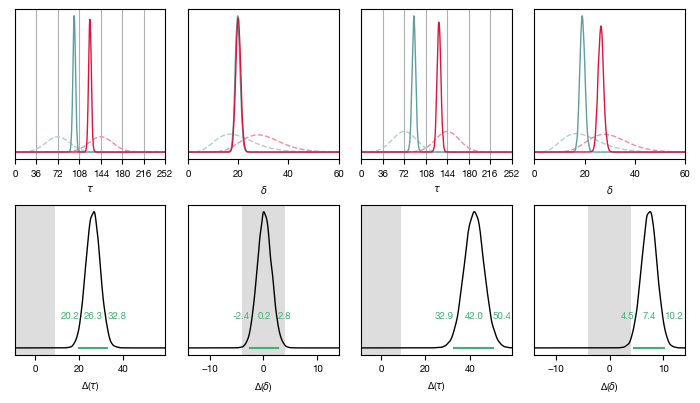

In [30]:
with Figure(n_cols=4, n_rows=2, width='double', height=100) as fig:
    # above
    plots.plot_prior(fig[0,0], exp2, 'τ')
    plots.plot_prior(fig[0,1], exp2, 'δ')
    plots.plot_posterior(fig[0,0], exp2, 'τ', posterior_file=MODEL_FIT / 'exp2_posterior_above.nc')
    plots.plot_posterior(fig[0,1], exp2, 'δ', posterior_file=MODEL_FIT / 'exp2_posterior_above.nc')
    plots.plot_posterior_difference(fig[1,0], exp2, 'τ', hdi=0.95, rope=(-9, 9), xlim=(-9, 59), posterior_file=MODEL_FIT / 'exp2_posterior_above.nc')
    plots.plot_posterior_difference(fig[1,1], exp2, 'δ', hdi=0.95, rope=(-4, 4), xlim=(-14, 14), posterior_file=MODEL_FIT / 'exp2_posterior_above.nc')
    plots.draw_letter_grid(fig[0,0], letter_width=36, n_letters=7)
    # below
    plots.plot_prior(fig[0,2], exp2, 'τ')
    plots.plot_prior(fig[0,3], exp2, 'δ')
    plots.plot_posterior(fig[0,2], exp2, 'τ', posterior_file=MODEL_FIT / 'exp2_posterior_below.nc')
    plots.plot_posterior(fig[0,3], exp2, 'δ', posterior_file=MODEL_FIT / 'exp2_posterior_below.nc')
    plots.plot_posterior_difference(fig[1,2], exp2, 'τ', hdi=0.95, rope=(-9, 9), xlim=(-9, 59), posterior_file=MODEL_FIT / 'exp2_posterior_below.nc')
    plots.plot_posterior_difference(fig[1,3], exp2, 'δ', hdi=0.95, rope=(-4, 4), xlim=(-14, 14), posterior_file=MODEL_FIT / 'exp2_posterior_below.nc')
    plots.draw_letter_grid(fig[0,2], letter_width=36, n_letters=7)

There is a difference in targeting behaviour regardless of whether you look at word-above trials (left panels) or word-below trials (right panels). However, in the case of dispersion, there's only a clear difference between conditions in the case of the word-below trials. It is unclear why this might be the case. Here are a few possibilities we can think of:

- The eye tracker was positioned below the screen, meaning that tracking calibration should be better when the participant gazes down towards the tracker. Thus, perhaps we have less measurement error in the case of downward trials, which allows the true effects to manifest themselves (i.e. in the case of upwards trials, the differences in dispersion become masked behind measurement noise).

- Perhaps general occularmotor control is less restricted in downward saccades, allowing participants to produce more essentric and dispersed landing positions.

- Participants more often produce downward saccades during normal reading, so maybe there's some form of practice effect where they find it easier to target words in a downwards direction.

- During training, participants first look at the object stimulus and then move their gaze down to the word (which appears after a short delay), so perhaps they become more trained in accurately targeting the words in a downwards direction.

Finally, here's a detailed table of all the parameter estimates:

In [31]:
posteriors = [
    ('exp2_posterior.nc', 'Canonical posterior parameter estimates'),
    ('exp2_posterior_uniform.nc', 'Posterior estimated with uniform priors'),
    ('exp2_posterior_indy_ζξ.nc', "Posterior estimated with independent ζ's and ξ's"),
    ('exp2_posterior_above.nc', 'Posterior estimated from word-above trials only'),
    ('exp2_posterior_below.nc', 'Posterior estimated from word-below trials only'),
]

for filename, title in posteriors:
    trace = arviz.from_netcdf(MODEL_FIT / filename)
    table = arviz.summary(trace, hdi_prob=0.95, var_names=['τ', 'δ', 'ζ', 'ξ', 'Δ(τ)', 'Δ(δ)'])
    table = table[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%', 'ess_bulk', 'r_hat']]
    print(title)
    print(table)

Canonical posterior parameter estimates
             mean     sd  hdi_2.5%  hdi_97.5%  ess_bulk  r_hat
τ[left]    94.007  2.461    89.212     98.885   19656.0    1.0
τ[right]  127.781  2.446   123.109    132.685   18104.0    1.0
δ[left]    21.721  0.818    20.142     23.340   16667.0    1.0
δ[right]   24.248  0.833    22.590     25.865   16661.0    1.0
ζ          14.667  1.305    12.137     17.225   17465.0    1.0
ξ           4.614  0.498     3.678      5.602   10679.0    1.0
Δ(τ)       33.774  3.493    27.032     40.615   19123.0    1.0
Δ(δ)        2.527  1.153     0.288      4.839   18546.0    1.0
Posterior estimated with uniform priors
             mean     sd  hdi_2.5%  hdi_97.5%  ess_bulk  r_hat
τ[left]    94.358  2.485    89.526     99.248   20238.0    1.0
τ[right]  127.536  2.523   122.598    132.525   19739.0    1.0
δ[left]    21.767  0.820    20.111     23.343   15501.0    1.0
δ[right]   24.211  0.853    22.539     25.898   14412.0    1.0
ζ          14.686  1.283    12.299    

## Experiment 3

To explore the Experiment 3 code, see `experiments/exp3/`.

First, some notes on the preprocessing of the eyetracking data. For each participant, the experiment script produces three files: `01.json`, `01.edf`, and `01.asc`. The JSON file stores all the data about trial order, button clicks etc, the EDF file stores the raw eyetracker recording, and the ASC file is a conversion of the EDF file to an open format (produced using EyeLink's `edf2asc` tool).

From the ASC file, we extract the fixation sequence and store it inside the JSON file to keep everything neatly organized together. The raw ASC and EDF files are not committed to the repo because they are very large (contact me if you want this raw data). The extraction process is run like this:

```python
from code import merge_fixation_data_exp3
merge_fixation_data_exp3.merge_fixations_into_user_data(json_path, asc_path)
```

This uses Eyekit to extract the fixations from the ASC file and then inserts them into the JSON file. It also performs a number of checks to make sure the recordings in the ASC file match the trials in the JSON file, and also creates Eyekit TextBlock objects for each trial (also stored in the JSON).

Alternatively, the extraction process can be run from the command line, e.g.:

```bash
$ python code/merge_fixation_data_exp3.py exp3_left 01
```

Note, however, that the JSON files committed to the repo have already been processed, so **it is not necessary to run any of these preprocessing steps unless you need to reproduce the data for some reason**.

Like Experiment 1 and 2, the Experiment 3 dataset will be loaded into an `Experiment` object, and before getting started we need to set up the exclusion threshold and parameters/priors.

In [32]:
exp3 = Experiment('exp3')

exp3.set_exclusion_threshold(7, 8)

exp3.set_params({
    'τ': (0, 252),
    'δ': (0, 60),
    'ζ': (0, 40),
    'ξ': (0, 40),
})

exp3.set_priors({
    'δ': ('gamma', (23., 10.)),
    'ζ': ('exponential', (0.1,)),
    'ξ': ('exponential', (0.1,)),
})

exp3.left.set_priors({
    'τ': ('normal', (94., 30.)),
})

exp3.right.set_priors({
    'τ': ('normal', (128., 30.)),
})

Print median completion time:

In [33]:
exp3.print_median_completion_time(use_first_trial_time=False)

Median completion time of 38 minutes


Print details about the number of exclusions and valid trials:

In [34]:
exp3.print_n_exclusion_stats()
exp3.left.print_n_exclusion_stats()
exp3.right.print_n_exclusion_stats()

exp3
54 participants completed training
51 participants remain after training exclusions
- 51 complete datasets (on average 60.4 trials were valid)
Total valid trials: 3080 (94.363)
exp3_left
28 participants completed training
25 participants remain after training exclusions
- 25 complete datasets (on average 59.9 trials were valid)
Total valid trials: 1497 (93.562)
exp3_right
26 participants completed training
26 participants remain after training exclusions
- 26 complete datasets (on average 60.9 trials were valid)
Total valid trials: 1583 (95.132)


Print details about overall test accuracy:

In [35]:
exp3.print_test_accuracy()

exp3_left: median = 0.984375, IQR = 0.96875 -- 1.0
exp3_right: median = 0.96875, IQR = 0.9375 -- 1.0


Make plots of the overall experimental results:

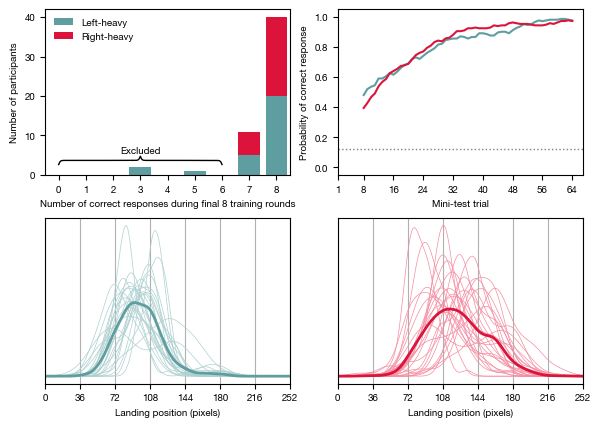

In [36]:
with Figure(n_rows=2, n_cols=2, width=150) as fig:
    plots.plot_learning_scores(fig[0,0], exp3)
    plots.plot_learning_curve(fig[0,1], exp3)
    plots.plot_landing_curve(fig[1,0], exp3.left, show_average=True)
    plots.plot_landing_curve(fig[1,1], exp3.right, show_average=True)

### Fitting statistical model

Fitting the statistical model requires PyMC and will take some time to run. The posteriors have already been computed and are stored as NetCDF files under `data/model_fit/`. However, if you want to reproduce the results or play around with the details, you should take a look at `code/landing_model_exp3.py`.

To fit the statistical model, run:

```bash
$ python code/landing_model_exp3.py
```

I ran the model with six chains of 2500 samples (+ 500 tuning samples); to adjust these parameters or check out the other available options, run this command:

```bash
$ python code/landing_model.py --help
```

The posterior trace is stored in `data/model_fit/exp3_posterior.nc`. Here is a summary table:

In [37]:
trace = arviz.from_netcdf(MODEL_FIT / 'exp3_posterior.nc')
table = arviz.summary(trace, hdi_prob=0.95, var_names=['τ', 'δ', 'ζ', 'ξ', 'Δ(τ)'])
table = table[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%', 'ess_bulk', 'r_hat']]
print(table)

             mean     sd  hdi_2.5%  hdi_97.5%  ess_bulk  r_hat
τ[left]    97.410  3.011    91.630    103.373   18859.0    1.0
τ[right]  123.579  2.959   117.761    129.309   19468.0    1.0
δ          22.513  0.871    20.893     24.294   15068.0    1.0
ζ          14.820  1.552    11.987     17.927   18620.0    1.0
ξ           5.814  0.718     4.474      7.253   13023.0    1.0
Δ(τ)       26.169  4.216    17.812     34.231   19380.0    1.0


All R-hats are 1 and all ESS > 10,000, so diagnostics are all good. The parameter estimates hint at a 26 pixel difference in targeted positions (i.e. Δ(τ)). This is down a bit from Experiment 2. Dispersion is about the same as Experiment 2. Here's a figure plotting the priors and posteriors (top row), as well as the posterior differences between the left- and right-heavy conditions:

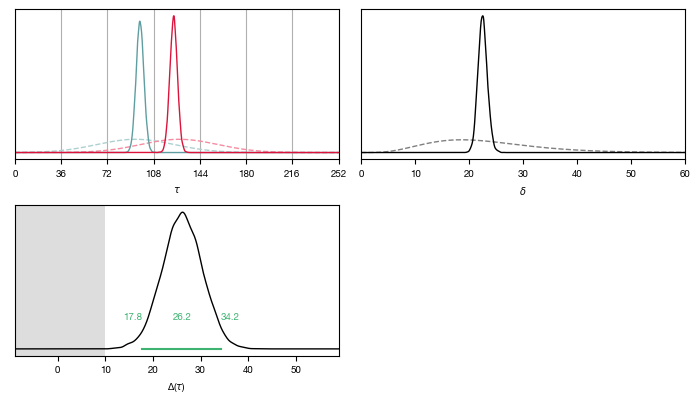

In [38]:
with Figure(n_cols=2, n_rows=2, width='double', height=100) as fig:
    plots.plot_prior(fig[0,0], exp3, 'τ')
    plots.plot_prior(fig[0,1], exp3, 'δ')
    plots.plot_posterior(fig[0,0], exp3, 'τ')
    plots.plot_posterior(fig[0,1], exp3, 'δ')
    plots.plot_posterior_difference(fig[1,0], exp3, 'τ', hdi=0.95, rope=(-10, 10), xlim=(-9, 59))
    plots.draw_letter_grid(fig[0,0], letter_width=36, n_letters=7)

The posterior difference is above the ROPE, so we accept the hypothesis.

The following plot shows Normal landing distributions using the partially-pooled parameter estimates, not just for each condition, but also for each participant. Participants whose data were unreliable or divergent will be shrunk towards the group level estimates.

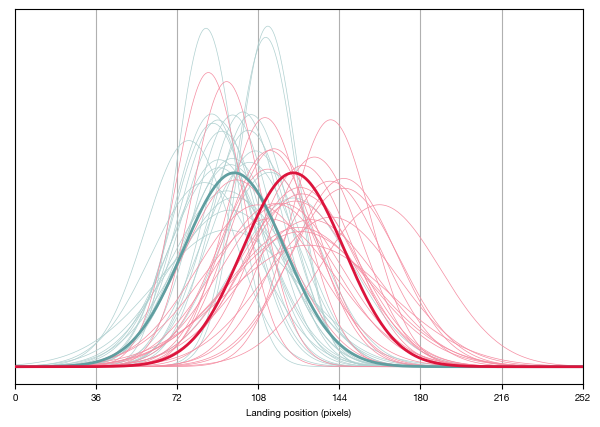

In [39]:
with Figure(width=150) as fig:
    plots.plot_landing_curve_fits(fig, exp3)

I also run a full version of the model, with all parameters stratified by condition, to see if anything interesting was going on. The results are stored in `exp3_posterior_full.nc`. Here's a plot of the posteriors:

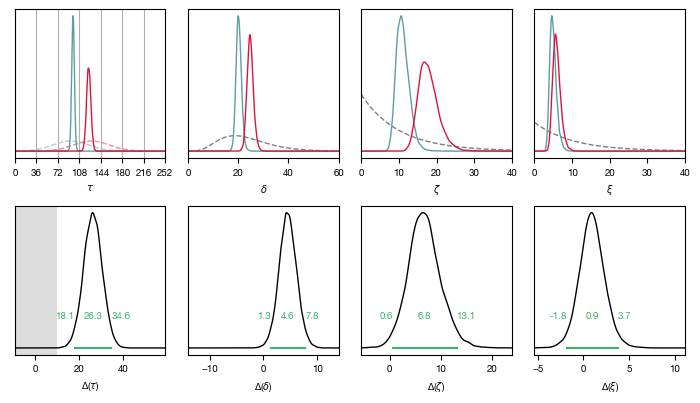

In [40]:
with Figure(n_cols=4, n_rows=2, width='double', height=100) as fig:

    plots.plot_prior(fig[0,0], exp3, 'τ')
    plots.plot_prior(fig[0,1], exp3, 'δ')
    plots.plot_posterior(fig[0,0], exp3, 'τ', posterior_file=MODEL_FIT / 'exp3_posterior_full.nc')
    plots.plot_posterior(fig[0,1], exp3, 'δ', posterior_file=MODEL_FIT / 'exp3_posterior_full.nc')
    plots.plot_posterior_difference(fig[1,0], exp3, 'τ', hdi=0.95, rope=(-10, 10), xlim=(-9, 59), posterior_file=MODEL_FIT / 'exp3_posterior_full.nc')
    plots.plot_posterior_difference(fig[1,1], exp3, 'δ', hdi=0.95, xlim=(-14, 14), posterior_file=MODEL_FIT / 'exp3_posterior_full.nc')
    plots.draw_letter_grid(fig[0,0], letter_width=36, n_letters=7)

    plots.plot_prior(fig[0,2], exp3, 'ζ')
    plots.plot_prior(fig[0,3], exp3, 'ξ')
    plots.plot_posterior(fig[0,2], exp3, 'ζ', posterior_file=MODEL_FIT / 'exp3_posterior_full.nc')
    plots.plot_posterior(fig[0,3], exp3, 'ξ', posterior_file=MODEL_FIT / 'exp3_posterior_full.nc')
    plots.plot_posterior_difference(fig[1,2], exp3, 'ζ', hdi=0.95, posterior_file=MODEL_FIT / 'exp3_posterior_full.nc')
    plots.plot_posterior_difference(fig[1,3], exp3, 'ξ', hdi=0.95, posterior_file=MODEL_FIT / 'exp3_posterior_full.nc')

Running the model this way has little impact on the estimates for τ, so those results are reliable. Interestingly, we do now seem to have a dispersion effect, although it's still pretty small. In the case of ζ, there is some evidence of more across-participant variation in targeting in the right-heavy condition.

To check that the posteriors were not unduely influenced by the priors, we also ran it with uniform priors. The results are stored in `exp3_posterior_uniform.nc` and here's a plot of the results:

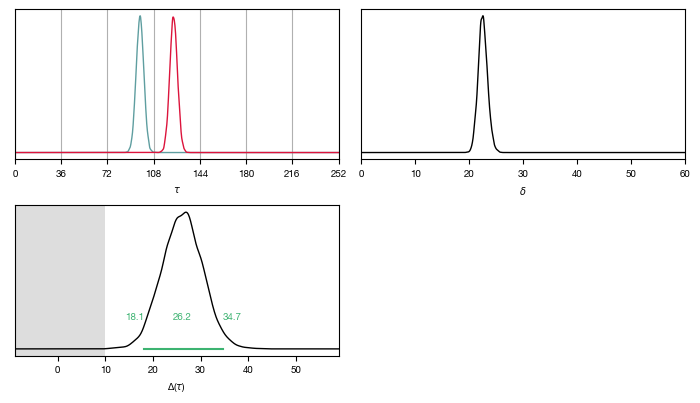

In [41]:
with Figure(n_cols=2, n_rows=2, width='double', height=100) as fig:
    plots.plot_posterior(fig[0,0], exp3, 'τ', posterior_file=MODEL_FIT / 'exp3_posterior_uniform.nc')
    plots.plot_posterior(fig[0,1], exp3, 'δ', posterior_file=MODEL_FIT / 'exp3_posterior_uniform.nc')
    plots.plot_posterior_difference(fig[1,0], exp3, 'τ', hdi=0.95, rope=(-10, 10), xlim=(-9, 59), posterior_file=MODEL_FIT / 'exp3_posterior_uniform.nc')
    plots.draw_letter_grid(fig[0,0], letter_width=36, n_letters=7)

Using uniform priors does not make any meaningful difference to the results, so nothing to worry about.

Finally, here's a detailed table of all the parameter estimates:

In [42]:
posteriors = [
    ('exp3_posterior.nc', 'Canonical posterior parameter estimates'),
    ('exp3_posterior_uniform.nc', 'Posterior estimated with uniform priors'),
    ('exp3_posterior_full.nc', "Posterior estimated with independent δ's, ζ's, and ξ's"),
]

for filename, title in posteriors:
    trace = arviz.from_netcdf(MODEL_FIT / filename)
    table = arviz.summary(trace, hdi_prob=0.95, var_names=['τ', 'δ', 'ζ', 'ξ', 'Δ(τ)'])
    table = table[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%', 'ess_bulk', 'r_hat']]
    print(title)
    print(table)

Canonical posterior parameter estimates
             mean     sd  hdi_2.5%  hdi_97.5%  ess_bulk  r_hat
τ[left]    97.410  3.011    91.630    103.373   18859.0    1.0
τ[right]  123.579  2.959   117.761    129.309   19468.0    1.0
δ          22.513  0.871    20.893     24.294   15068.0    1.0
ζ          14.820  1.552    11.987     17.927   18620.0    1.0
ξ           5.814  0.718     4.474      7.253   13023.0    1.0
Δ(τ)       26.169  4.216    17.812     34.231   19380.0    1.0
Posterior estimated with uniform priors
             mean     sd  hdi_2.5%  hdi_97.5%  ess_bulk  r_hat
τ[left]    97.412  2.998    91.408    103.163   19173.0    1.0
τ[right]  123.591  3.011   117.497    129.326   21667.0    1.0
δ          22.546  0.870    20.888     24.318   13293.0    1.0
ζ          14.826  1.565    11.964     17.972   18161.0    1.0
ξ           5.812  0.708     4.472      7.194   12797.0    1.0
Δ(τ)       26.179  4.256    18.149     34.673   19629.0    1.0
Posterior estimated with independent δ

## Experiment 1 model fit – Test of parameter recovery

As a sanity check on the Experiment 1 model fit, let's make sure known parameters can be recovered from a simulated dataset.

In [43]:
# pick some parameter settings
TRUE_PARAMS = [0.8, 0.2, 0.3, 0.1]

# create synthetic dataset (30 participants in each condition)
dataset_l = model.simulate_dataset(exp1.left.lexicon, TRUE_PARAMS, 30, lexicon_index=0)
dataset_r = model.simulate_dataset(exp1.right.lexicon, TRUE_PARAMS, 30, lexicon_index=1)
dataset = dataset_l + dataset_r

# save the dataset
# json_write(dataset, MODEL_FIT / 'synth1_dataset.json')

Then we run the model fit with commands like the following. All settings are the same as those used for the actual model fit; the only difference here is that we use the synthetic data generated above instead of the actual experimental data.

```bash
$ python code/model_fit.py run 0 --output_file data/model_fit/synth1_posterior.nc --dataset_override data/model_fit/synth1_dataset.json
...
$ python code/model_fit.py run 5 --output_file data/model_fit/synth1_posterior.nc --dataset_override data/model_fit/synth1_dataset.json
$ python code/model_fit.py merge 6 --output_file data/model_fit/synth1_posterior.nc
```

Print the posterior parameter estimates:

In [44]:
trace = arviz.from_netcdf(MODEL_FIT / 'synth1_posterior.nc')
table = arviz.summary(trace, hdi_prob=0.95)
table['true value'] = TRUE_PARAMS
table = table[['true value', 'mean', 'hdi_2.5%', 'hdi_97.5%']]
print(table)

   true value   mean  hdi_2.5%  hdi_97.5%
α         0.8  0.801     0.730      0.879
β         0.2  0.219     0.179      0.256
γ         0.3  0.292     0.185      0.405
ε         0.1  0.082     0.044      0.123


The true values are all pretty close to the estimates from the model fit and certainly contained within the 95% HDIs, so, in principle at least, it is possible to recover model parameter values from a dataset.